In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [23]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'SaltID/train/'
path_test = 'SaltID/test/'

In [13]:
PATH = os.path.abspath("../Thinkful Projects/SaltID")
PATH

'C:\\Users\\e.istre91\\Thinkful Projects\\SaltID'

In [26]:
file_list = glob(os.path.join(PATH, "**/*.png"), recursive=True)

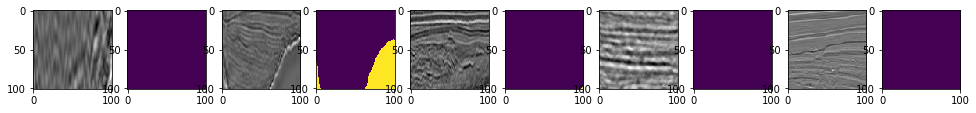

In [21]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread('SaltID/train/images/' + img_name + '.png')
    img_mask = imread('SaltID/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [24]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [30]:
depths = pd.read_csv("SaltID/depths.csv")
print(depths['z'].min(), depths['z'].max())

50 959


In [190]:
imread(path + '/images/' + id_, as_gray=True)

array([[0.40784314, 0.43137255, 0.47058824, ..., 0.34509804, 0.33333333,
        0.31372549],
       [0.30196078, 0.31764706, 0.36078431, ..., 0.28235294, 0.26666667,
        0.25490196],
       [0.25490196, 0.25490196, 0.28235294, ..., 0.27058824, 0.25490196,
        0.2627451 ],
       ...,
       [0.34509804, 0.34901961, 0.35686275, ..., 0.34901961, 0.34901961,
        0.34901961],
       [0.34509804, 0.34901961, 0.34901961, ..., 0.34901961, 0.34901961,
        0.34901961],
       [0.34509804, 0.34901961, 0.34901961, ..., 0.34901961, 0.34901961,
        0.34509804]])

In [288]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = imread(path + '/images/' + id_)
    x = img
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = imread(path + '/masks/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='constant', 
                        anti_aliasing=False,
                        preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [289]:
X_train = X_train.reshape(-1, 1, 128, 128)
Y_train = Y_train.reshape(-1, 1, 128, 128)

In [290]:
Y_train = Y_train.astype(np.uint8)

TypeError: Invalid dimensions for image data

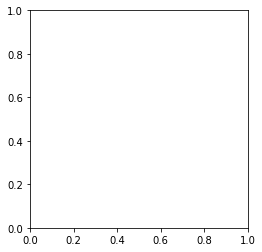

In [207]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [291]:
batch_size = 100
n_iters = 40
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=X_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

#test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                          batch_size=batch_size, 
#                                          shuffle=False)

In [292]:
def conv_relu(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

def double_conv(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1 (?)
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(1, 8, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(8, 16, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(16, 32, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(32, 64, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(64, 128, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(128, 64, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(128, 64, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(64, 32, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(64, 32, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(32, 16, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(32, 16, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(16, 8, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(16, 8, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(8, 1, 1, 1, 0)
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)
        print(conv1.size(), maxpool1.size())

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        print(conv2.size(), maxpool2.size())

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)
        print(conv3.size(), maxpool3.size())

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
        print(conv4.size(), maxpool4.size())
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        print(conv5.size())
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        print(t_conv4.size(), ex_conv4.size())
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)
        print(t_conv3.size(), ex_conv3.size())

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        print(t_conv2.size(), ex_conv2.size())
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        print(t_conv1.size(), ex_conv1.size())
        
        one_by_one = self.one_by_one(ex_conv1)
        print(one_by_one.size())
        
        return one_by_one

In [293]:
model = Unet()
model.cuda()

Unet(
  (double_conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1,

In [294]:
criterion = nn.CrossEntropyLoss()

In [295]:
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [300]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):        
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels[i])
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                images = Variable(images.cuda())
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted.cpu() == labels.cpu()).sum()
                            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

torch.Size([100, 8, 128, 128]) torch.Size([100, 8, 64, 64])
torch.Size([100, 16, 64, 64]) torch.Size([100, 16, 32, 32])
torch.Size([100, 32, 32, 32]) torch.Size([100, 32, 16, 16])
torch.Size([100, 64, 16, 16]) torch.Size([100, 64, 8, 8])
torch.Size([100, 128, 8, 8])
torch.Size([100, 64, 16, 16]) torch.Size([100, 64, 16, 16])
torch.Size([100, 32, 32, 32]) torch.Size([100, 32, 32, 32])
torch.Size([100, 16, 64, 64]) torch.Size([100, 16, 64, 64])
torch.Size([100, 8, 128, 128]) torch.Size([100, 8, 128, 128])
torch.Size([100, 1, 128, 128])


ValueError: Expected input batch_size (100) to match target batch_size (128).

In [284]:
#nope

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''

model = CNNModel()

#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                else:
                    images = Variable(images)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

In [152]:
dir(train_dataset)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 'download',
 'processed_folder',
 'raw_folder',
 'root',
 'target_transform',
 'test_file',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'urls']

In [157]:
train_dataset.train_labels[9]

tensor(4)